In [1]:
import pandas as pd


import numpy as np
import pandas as pd

import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime

In [2]:
path = '/home/bhatti/dataset/VCHAMPS/procedures_train.csv'
procedures = pd.read_csv(path).iloc[:,1:]
procedures

,Internalpatientid,Age at procedure,Procedure date,Procedure code,Procedure code description,State
0,1,57.573116,2001-10-30 23:22:22.0,90658,"INFLUENZA VIRUS VACCINE, TRIVALENT (IIV3), SPL...",Indiana
1,1,57.573116,2001-10-30 23:22:22.0,90471,IMMUNIZATION ADMINISTRATION (INCLUDES PERCUTAN...,Indiana
2,1,57.573116,2001-10-30 23:22:22.0,99212,OFFICE OR OTHER OUTPATIENT VISIT FOR THE EVALU...,Indiana
3,1,57.912086,2002-03-03 20:49:01.0,84460,TRANSFERASE; ALANINE AMINO (ALT) (SGPT),Indiana
4,1,57.912086,2002-03-03 20:49:01.0,84450,TRANSFERASE; ASPARTATE AMINO (AST) (SGOT),Indiana
...,...,...,...,...,...,...
103020499,99999,95.894208,2012-10-22 07:59:26.0,98968,TELEPHONE ASSESSMENT AND MANAGEMENT SERVICE PR...,California
103020500,99999,96.029365,2012-12-10 17:35:21.0,99215,OFFICE OR OTHER OUTPATIENT VISIT FOR THE EVALU...,Arizona
103020501,99999,96.029365,2012-12-10 17:35:21.0,90935,HEMODIALYSIS PROCEDURE WITH SINGLE EVALUATION ...,Arizona
103020502,99999,96.324691,2013-03-28 16:11:17.0,99215,OFFICE OR OTHER OUTPATIENT VISIT FOR THE EVALU...,Arizona


Procedure code description: why the patient come to the hospital

In [3]:
procedures.shape

(103020504, 6)

In [4]:
procedures.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103020504 entries, 0 to 103020503
Data columns (total 6 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   Internalpatientid           int64  
 1   Age at procedure            float64
 2   Procedure date              object 
 3   Procedure code              object 
 4   Procedure code description  object 
 5   State                       object 
dtypes: float64(1), int64(1), object(4)
memory usage: 4.6+ GB


In [5]:
procedures['Procedure code description'].nunique()

27744

In [6]:
procedures = procedures.drop_duplicates(subset = ['Internalpatientid', 'Procedure date','Procedure code description'],keep = 'first')

### Add New features: 
Number of procedures

Number of surgery procedures

Minimum number of surgery procedures

Maximum number of surgery procedures

In [7]:
surgery_pro = procedures.loc[procedures['Procedure code description'].str.contains('SURG')]
surgery_pro['num_surgery_pro'] = surgery_pro['Procedure code'].groupby(surgery_pro['Internalpatientid']).transform('count')

/tmp/ipykernel_44646/3717331933.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  surgery_pro['num_surgery_pro'] = surgery_pro['Procedure code'].groupby(surgery_pro['Internalpatientid']).transform('count')


In [8]:
procedures['total_procedure'] = procedures['Procedure code description'].groupby(procedures['Internalpatientid']).transform('count')

/tmp/ipykernel_44646/547977753.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  procedures['total_procedure'] = procedures['Procedure code description'].groupby(procedures['Internalpatientid']).transform('count')


## EDA

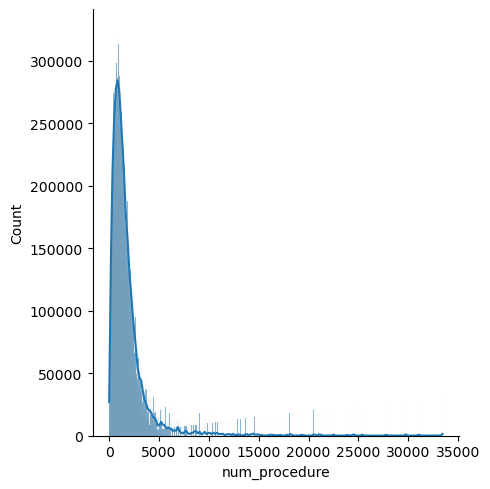

In [7]:
sns.displot(data=procedures, x='total_procedure', kde=True)

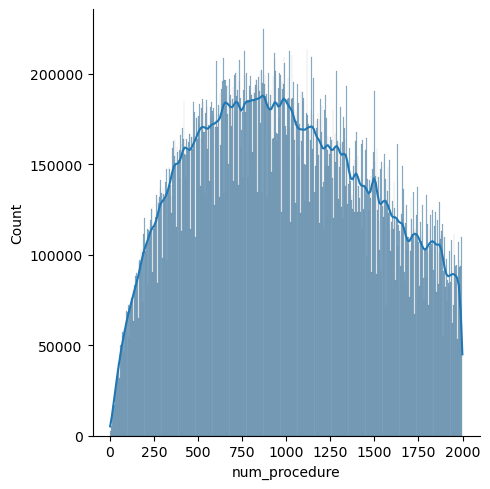

: 

In [8]:
sns.displot(data=procedures.loc[procedures['total_procedure'] < 2000], x='total_procedure', kde=True)

In [9]:
procedures.columns

Index(['Internalpatientid', 'Age at procedure', 'Procedure date',
       'Procedure code', 'Procedure code description', 'State',
       'num_procedure'],
      dtype='object')

### Save Cleaned procedures

In [13]:
columns = ['Internalpatientid', 'total_procedure']
df = procedures[columns]
df = df.groupby('Internalpatientid').mean().reset_index(drop = False)
df = df.merge(surgery_pro[['Internalpatientid','num_surgery_pro']], how = 'left',on = 'Internalpatientid')
df = df.groupby('Internalpatientid').mean().reset_index(drop = False)
df['num_surgery_pro'] = df['num_surgery_pro'].fillna(0)
df

,Internalpatientid,total_procedure,num_surgery_pro
0,1,1452.0,7.0
1,2,2406.0,14.0
2,3,188.0,0.0
3,4,583.0,0.0
4,5,243.0,1.0
...,...,...,...
133241,169060,1528.0,3.0
133242,169061,153.0,0.0
133243,169062,483.0,1.0
133244,169063,133.0,0.0


In [14]:

#df.to_csv('/home/daisy/FDA_Dataset/procedures_clean.csv')

## Remove skewness

In [16]:
num_col = list(set(list(df._get_numeric_data().columns)))
num_col

['Internalpatientid', 'num_surgery_pro', 'total_procedure']

In [17]:
# Removing skewnewss and kurtosis using log transformation if it is above a threshold value -  2
def remove_skewness(df):
    statdataframe = pd.DataFrame()
    statdataframe['numeric_column'] = num_col
    skew_before = []
    skew_after = []

    kurt_before = []
    kurt_after = []

    standard_deviation_before = []
    standard_deviation_after = []

    log_transform_needed = []

    log_type = []

    for i in num_col:
        skewval = df[i].skew()
        skew_before.append(skewval)
        
        kurtval = df[i].kurtosis()
        kurt_before.append(kurtval)
        
        sdval = df[i].std()
        standard_deviation_before.append(sdval)
        
        if (abs(skewval) >2) & (abs(kurtval) >2):
            log_transform_needed.append('Yes')
            
            if len(df[df[i] == 0])/len(df) <=0.02:
                log_type.append('log')
                skewvalnew = np.log(pd.DataFrame(df[df[i] > 0])[i]).skew()
                skew_after.append(skewvalnew)
                
                kurtvalnew = np.log(pd.DataFrame(df[df[i] > 0])[i]).kurtosis()
                kurt_after.append(kurtvalnew)
                
                sdvalnew = np.log(pd.DataFrame(df[df[i] > 0])[i]).std()
                standard_deviation_after.append(sdvalnew)
                
            else:
                log_type.append('log1p')
                skewvalnew = np.log1p(pd.DataFrame(df[df[i] >= 0])[i]).skew()
                skew_after.append(skewvalnew)
            
                kurtvalnew = np.log1p(pd.DataFrame(df[df[i] >= 0])[i]).kurtosis()
                kurt_after.append(kurtvalnew)
                
                sdvalnew = np.log1p(pd.DataFrame(df[df[i] >= 0])[i]).std()
                standard_deviation_after.append(sdvalnew)
                
        else:
            log_type.append('NA')
            log_transform_needed.append('No')
            
            skew_after.append(skewval)
            kurt_after.append(kurtval)
            standard_deviation_after.append(sdval)

    statdataframe['skew_before'] = skew_before
    statdataframe['kurtosis_before'] = kurt_before
    statdataframe['standard_deviation_before'] = standard_deviation_before
    statdataframe['log_transform_needed'] = log_transform_needed
    statdataframe['log_type'] = log_type
    statdataframe['skew_after'] = skew_after
    statdataframe['kurtosis_after'] = kurt_after
    statdataframe['standard_deviation_after'] = standard_deviation_after
    return statdataframe

In [18]:
remove_skewness(df)

,numeric_column,skew_before,kurtosis_before,standard_deviation_before,log_transform_needed,log_type,skew_after,kurtosis_after,standard_deviation_after
0,Internalpatientid,0.002741,-1.198382,48774.058173,No,NA,0.002741,-1.198382,48774.058173
1,num_surgery_pro,4.605397,41.814602,10.718719,Yes,log1p,0.590766,-0.820316,1.177373
2,total_procedure,5.953074,98.278510,901.203699,Yes,log,-0.960336,1.285363,1.348119


## Combine inpatient admission

In [19]:
path = '/home/hassan/lily/MLA/FDA/inpatient_admission_withtarget.csv'
inpatient = pd.read_csv(path).iloc[:,1:]
inpatient_sub = inpatient[['Internalpatientid', 'Died during admission','Cardiovascular', 'Readmission']]

In [20]:
inpatient_procedure = inpatient.merge(df, how = 'inner', on = 'Internalpatientid')
inpatient_procedure = inpatient_procedure.reset_index(drop = True)
inpatient_procedure

,Internalpatientid,Age at admission,Admission date,Discharge date,Admitting unit service,Discharging unit service,Admitting specialty,Discharging specialty,First listed discharge diagnosis icd10 subcategory,Second listed discharge diagnosis icd10 subcategory,Discharge disposition,Died during admission,Outpatientreferralflag,Serviceconnectedflag,Agentorangeflag,State,Cardiovascular,Readmission,total_procedure,num_surgery_pro
0,10,65.649075,2015-11-28 17:41:09.0,2015-11-29 01:43:14.0,NON-COUNT,NON-COUNT,DRUG DEPENDENCE TRMT UNIT,MEDICAL OBSERVATION,"Pneumonia, unspecified organism",Hypokalemia,Regular,0,1,NaN,1.0,Utah,0,0,392.0,1.0
1,100001,83.767138,2009-10-01 21:19:50.0,2009-10-04 16:51:33.0,MEDICINE,MEDICINE,PSYCHIATRIC MENTALLY INFIRM,GENERAL(ACUTE MEDICINE),"Pneumonia, unspecified organism",Essential (primary) hypertension,Regular,0,1,0.0,0.0,North Carolina,0,1,876.0,14.0
2,100001,84.873295,2010-11-10 04:32:39.0,2010-11-19 08:49:45.0,SURGERY,SURGERY,SUBSTANCE ABUSE RES TRMT PROG,ORTHOPEDIC,"Osteoarthritis, unspecified site",Type 2 diabetes mellitus with neurological com...,Regular,0,1,NaN,0.0,North Carolina,0,1,876.0,14.0
3,100001,84.898357,2010-11-19 08:23:30.0,2010-11-26 11:03:10.0,NHCU,NHCU,LONG TERM PSYCHIATRY(>45 DAYS),NH SHORT STAY REHABILITATION,Encounter for other specified aftercare,Presence of orthopedic joint implants ; Presen...,Regular,0,1,NaN,0.0,North Carolina,0,1,876.0,14.0
4,100001,86.568969,2012-07-21 23:00:00.0,2012-07-22 19:18:48.0,MEDICINE,MEDICINE,PM&R TRANSITIONAL REHAB,CARDIAC INTENSIVE CARE UNIT,"Atrioventricular block, second degree","Obesity, unspecified",Regular,0,1,NaN,0.0,North Carolina,0,1,876.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
522730,98736,88.876710,2008-01-10 10:30:12.0,2008-01-21 11:51:46.0,MEDICINE,MEDICINE,METABOLIC,MEDICAL ICU,Pneumonitis due to inhalation of food and vomit,Unspecified mental disorder due to known physi...,Death without autopsy,1,1,NaN,0.0,Mississippi,0,0,37.0,0.0
522731,98916,65.079672,2011-03-07 14:52:48.0,2011-03-08 10:58:45.0,MEDICINE,MEDICINE,OPHTHALMOLOGY,GENERAL(ACUTE MEDICINE),Type 2 diabetes mellitus with neurological com...,Opioid dependence,Regular,0,1,NaN,1.0,Michigan,0,0,1290.0,5.0
522732,9915,61.367001,2017-02-16 15:20:05.0,2017-02-22 20:12:34.0,MEDICINE,MEDICINE,TRANSPLANTATION,GENERAL(ACUTE MEDICINE),"Sepsis, unspecified organism",Infection and inflammatory reaction due to pro...,Regular,0,1,NaN,0.0,Puerto Rico,0,0,589.0,2.0
522733,99820,79.326955,2003-05-01 00:02:52.0,2003-05-19 09:17:02.0,MEDICINE,MEDICINE,GENERAL(ACUTE MEDICINE),Not specified (no value),Pneumonia due to Pseudomonas,Alcohol dependence,Regular,0,1,NaN,NaN,Nebraska,0,0,367.0,8.0


/tmp/ipykernel_44646/3037044385.py:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr(),


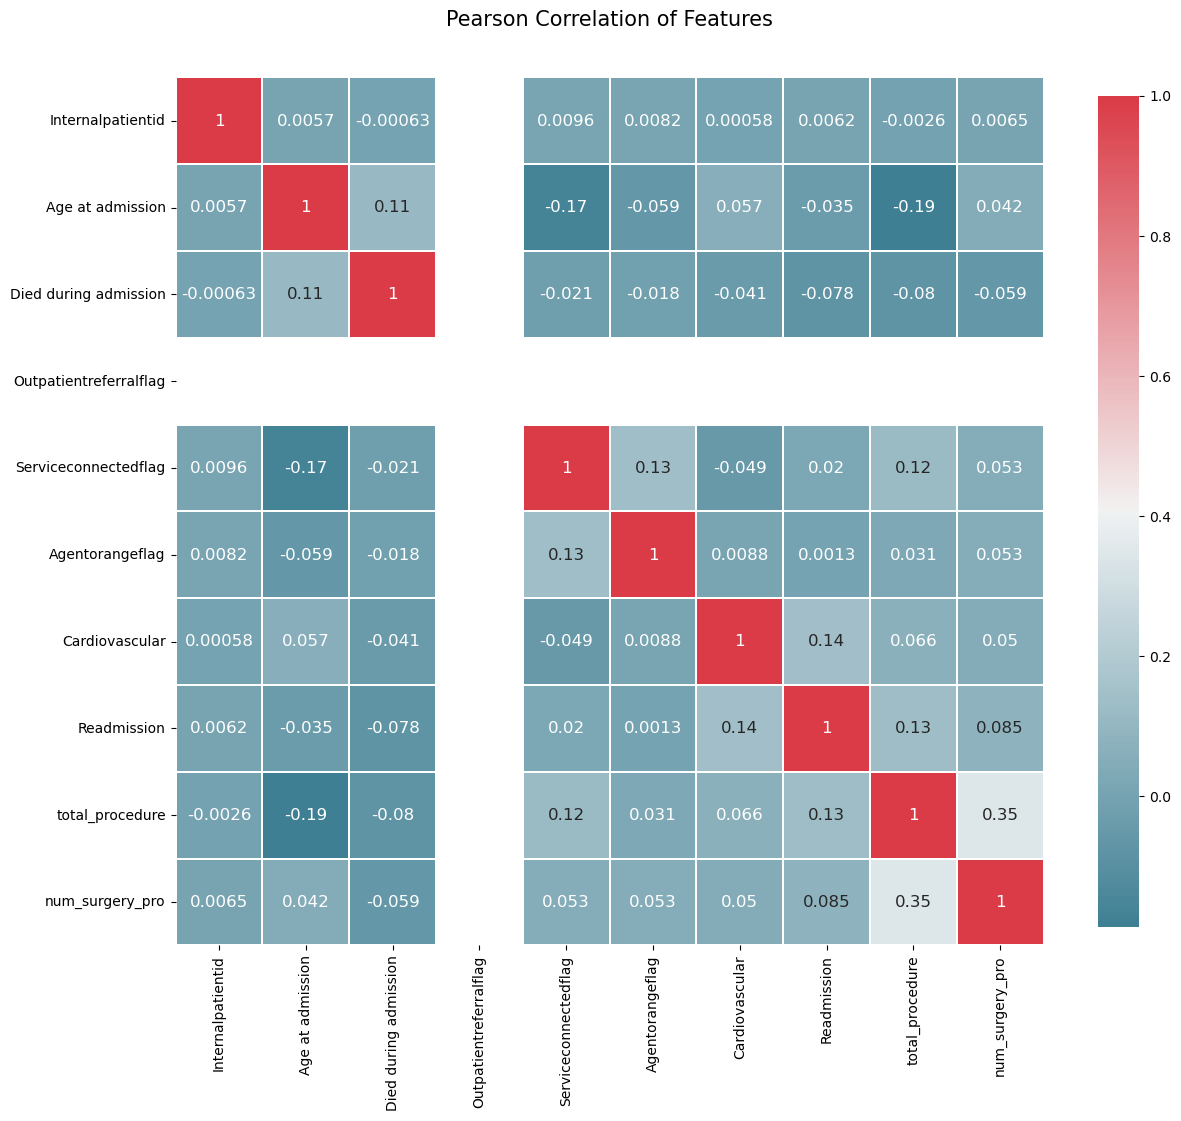

In [21]:
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

#correlation_heatmap(data[orig_cols+[target, target2]])
correlation_heatmap(inpatient_procedure)